# Initial Explorations for Beach Bacteria Project



In [44]:
import pandas as pd
import numpy as np



In [45]:
df = pd.read_excel("Riverkeeper Water Quality Data Set Download_2025.xlsx", sheet_name="Data")

In [46]:
print(df.head())

  Site Code                Site_Name    Sample_Date_Time  Latitude  Longitude  \
0         0  The Battery mid-channel 2025-09-16 13:44:00  40.70004  -74.02503   
1         0  The Battery mid-channel 2025-08-12 11:41:00  40.70004  -74.02503   
2         0  The Battery mid-channel 2025-07-21 12:53:00  40.70004  -74.02503   
3         0  The Battery mid-channel 2025-06-16 17:20:00  40.70004  -74.02503   
4         0  The Battery mid-channel 2025-05-13 11:40:00  40.70004  -74.02503   

  Enterococcus_Count  Temperature  Salinity  Chlorophyll  Phycocyanin  ...  \
0                <10       72.470     22.50         1.51         0.06  ...   
1                <10       76.300     24.30         1.80         0.25  ...   
2                 20       79.344     15.84         0.90         0.09  ...   
3                 10       66.061     14.97         1.15         0.24  ...   
4                 20       61.273      5.32         0.68          NaN  ...   

   Phycocyanin RFU  Turbidity  fDOM  Oxygen_

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22279 entries, 0 to 22278
Data columns (total 21 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Site Code                                       22279 non-null  object        
 1   Site_Name                                       21713 non-null  object        
 2   Sample_Date_Time                                22279 non-null  datetime64[ns]
 3   Latitude                                        21662 non-null  float64       
 4   Longitude                                       21662 non-null  float64       
 5   Enterococcus_Count                              22279 non-null  object        
 6   Temperature                                     8172 non-null   float64       
 7   Salinity                                        8078 non-null   float64       
 8   Chlorophyll                                   

In [ ]:
# utility functions for loading and processing water quality data

def load_water_data(df):
    # Add column with last bacteria measurement


    # Transform bacteria measurement into only numeric values
    df["Enterococcus_Count_numeric"] = df["Enterococcus_Count"].apply(bacteria_tonumeric)

    # Create label column based on current bacteria measurement
    df["beach_advisory"] = df["Enterococcus_Count_numeric"].apply(beach_eval)

    # Create cyclical numeric features
    df = parse_dates(df)
    df = df.sort_values("Sample_Date_Time")

    # Filter out rows with missing sonde data, and drop unnecessary columns
    df = df.drop(columns=['Site Code', 'Site_Name', 'Latitude', 'Longitude', 'Sample_Date_Time', 
                        'Partner Lab (most recently active; see README)', 'Enterococcus_Count', 
                        'Enterococcus_Count_numeric', 'doy'])
    df = df.dropna(subset=['Temperature', 
                            'Turbidity'])

    label_col = 'beach_advisory'

    features = [c for c in df.columns if c != label_col]

    
    
    y = df[label_col].to_numpy()
    X = df.drop(columns=[label_col]).to_numpy(dtype=float)
    return X, y, features

def bacteria_tonumeric(value):
    if pd.isna(value):
        return np.nan
    if value == '<10':
        return 1.0
    elif value == '>24196':
        return 24197.0
    else:
        return float(value)
    
def beach_eval(value):
    if pd.isna(value):
        return np.nan
    elif value > 104:
        return 1  # Beach advisory
    else:
        return 0  # No beach advisory
    
def parse_dates(df):
    df["doy"] = df["Sample_Date_Time"].dt.dayofyear
    df["sin_doy"] = np.sin(2 * np.pi * df["doy"] / 365)
    df["cos_doy"] = np.cos(2 * np.pi * df["doy"] / 365)
    return df

In [49]:
# split into x and y variables

X, y, features = load_water_data(df)


In [50]:
print(features)

['Temperature', 'Salinity', 'Chlorophyll', 'Phycocyanin', 'Chlorophyll RFU', 'Phycocyanin RFU', 'Turbidity', 'fDOM', 'Oxygen_percent', 'Oxygen', 'pH', 'Rain_day_of_sample', 'Rain_1_day_prior', 'Rain_2_days_prior', 'sin_doy', 'cos_doy']


In [51]:
print(X.shape, y.shape)

(7504, 16) (7504,)


In [52]:
# keeping consistent methods for cross validation and evaluation of accuracy
from sklearn.model_selection import StratifiedKFold, cross_val_score

def test_classifier(classifier, X, y):
    stratcv = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2023)
    print("Classifier type:", type(classifier).__name__)
    print("Classifier paramaters: ", classifier.get_params())

    accuracy = cross_val_score(classifier, X, y, cv=stratcv, 
                            scoring='accuracy')
    print("Classifier accuracy: ", np.mean(accuracy))

In [53]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score 

def test_classifier_timeseries(classifier, X, y):
    tscv = TimeSeriesSplit(n_splits=5)  # no shuffle!
    print("Classifier type:", type(classifier).__name__)
    print("Classifier parameters:", classifier.get_params())

    accuracy = cross_val_score(classifier, X, y, cv=tscv, scoring='accuracy')
    print("Classifier accuracy:", np.mean(accuracy))

In [ ]:
# Baseline RandomForests Classifier - with time series awareness
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()

test_classifier_timeseries(classifier, X, y)

Classifier type: RandomForestClassifier
Classifier parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Classifier accuracy: 0.82576


In [55]:
# Now fitting on whole dataset to get feature importances
classifier.fit(X, y)
importances = classifier.feature_importances_

importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

importance_df

,Feature,Importance
0,Temperature,0.117862
1,Salinity,0.071269
2,Chlorophyll,0.084320
3,Phycocyanin,0.008467
4,Chlorophyll RFU,0.086157
5,Phycocyanin RFU,0.008002
6,Turbidity,0.101296
7,fDOM,0.011423
8,Oxygen_percent,0.115298
9,Oxygen,0.013157


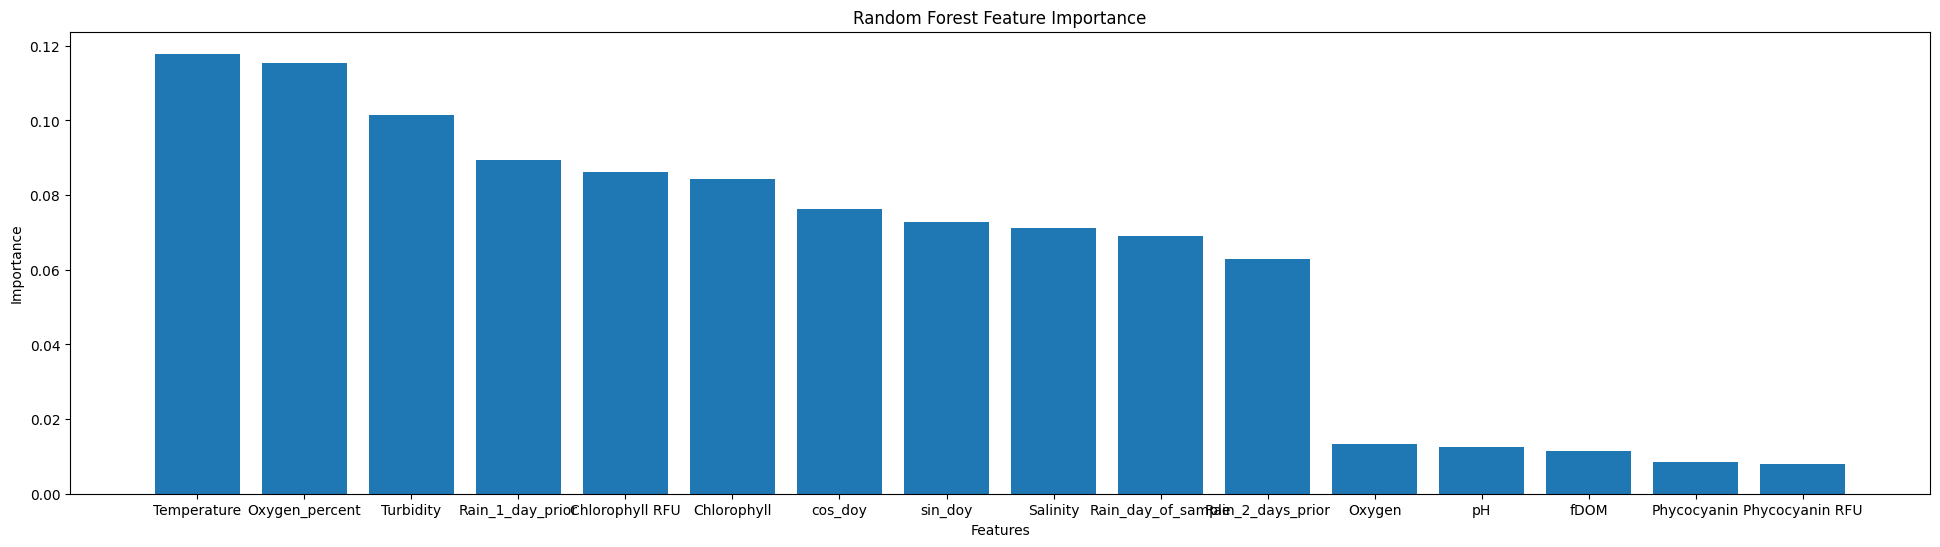

In [56]:
import matplotlib.pyplot as plt

importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(24, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()